In [1]:
import os
import wget
import math
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import scipy
import sklearn
import string
import tensorflow as tf
import torch 
from torch import nn
from collections import defaultdict # Dictionaries that take a default for missing entries
from sklearn import linear_model

/home/zhankui/anaconda3/envs/pml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_3/data` folder automatically.

In [2]:
filenames = ['beer_500.json', 'beer_50000.json', 'fantasy_100.json']

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)
print("Done!")

Done!


# Sigmoid function

In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + math.exp(-x))

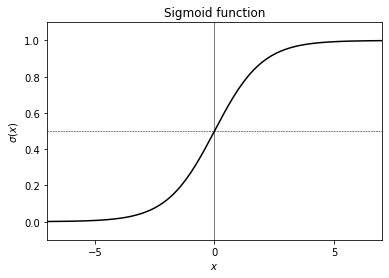

In [4]:
X = np.arange(-7,7.1,0.1)
Y = [sigmoid(x) for x in X]
plt.plot(X, Y, color='black')
plt.plot([0,0],[-2,2], color = 'black', linewidth=0.5)
plt.plot([-7,7],[0.5,0.5], color = 'k', linewidth=0.5, linestyle='--')
plt.xlim(-7, 7)
plt.ylim(-0.1, 1.1)
plt.xticks([-5,0,5])
plt.xlabel("$x$")
plt.ylabel(r"$\sigma(x)$")
plt.title("Sigmoid function")
plt.show()

# Implementing a simple classifier

Read a small dataset of beer reviews

In [5]:
path = os.path.join(dataDir, "beer_50000.json")
f = open(path)

data = []

for l in f:
    if 'user/gender' in l: # Discard users who didn't specify gender
        d = eval(l) # demjson is more secure but much slower!
        data.append(d)
    
f.close()

In [6]:
data[0]

{'review/appearance': 4.0,
 'beer/style': 'American Double / Imperial IPA',
 'review/palate': 4.0,
 'review/taste': 4.5,
 'beer/name': 'Cauldron DIPA',
 'review/timeUnix': 1293735206,
 'user/gender': 'Male',
 'user/birthdayRaw': 'Jun 16, 1901',
 'beer/ABV': 7.7,
 'beer/beerId': '64883',
 'user/birthdayUnix': -2163081600,
 'beer/brewerId': '1075',
 'review/timeStruct': {'isdst': 0,
  'mday': 30,
  'hour': 18,
  'min': 53,
  'sec': 26,
  'mon': 12,
  'year': 2010,
  'yday': 364,
  'wday': 3},
 'user/ageInSeconds': 3581417047,
 'review/overall': 4.0,
 'review/text': "According to the website, the style for the Caldera Cauldron changes every year. The current release is a DIPA, which frankly is the only cauldron I'm familiar with (it was an IPA/DIPA the last time I ordered a cauldron at the horsebrass several years back). In any event... at the Horse Brass yesterday.\t\tThe beer pours an orange copper color with good head retention and lacing. The nose is all hoppy IPA goodness, showcasing

Predict the user's gender from the length of their review

In [7]:
X = np.array([[1, len(d['review/text'])] for d in data])
y = np.array([d['user/gender'] == 'Female' for d in data])

Fit the model

In [8]:
mod = sklearn.linear_model.LogisticRegression()
mod.fit(X,y)

LogisticRegression()

Calculate the accuracy of the model

In [9]:
predictions = mod.predict(X) # Binary vector of predictions
correct = predictions == y # Binary vector indicating which predictions were correct
sum(correct) / len(correct)

0.9849041807577317

Accuracy seems surprisingly high! Check against the number of positive labels...

In [10]:
1 - (sum(y) / len(y))

0.9849041807577317

Accuracy is identical to the proportion of "males" in the data. Confirm that the model is never predicting positive

In [11]:
sum(predictions)

0

### Implementing a balanced classifier

Use the class_weight='balanced' option to implement the balanced classifier

In [12]:
mod = sklearn.linear_model.LogisticRegression(class_weight='balanced')
mod.fit(X,y)
predictions = mod.predict(X)

# Simple classification diagnostics

### Accuracy

Compute the accuracy of the balanced model

In [13]:
correct = predictions == y
sum(correct) / len(correct)

0.4225849139832378

### True positives, False positives (etc.), and balanced error rate (BER)

In [14]:
TP = sum([(p and l) for (p,l) in zip(predictions, y)])
FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
FN = sum([(not p and l) for (p,l) in zip(predictions, y)])

In [15]:
print(f"TP = {TP}")
print(f"FP = {FP}")
print(f"TN = {TN}")
print(f"FN = {FN}")

TP = 199
FP = 11672
TN = 8423
FN = 109


Can rewrite the accuracy in terms of these metrics

In [16]:
(TP + TN) / (TP + FP + TN + FN)

0.4225849139832378

### True positive and true negative rates

In [17]:
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

In [18]:
TPR,TNR

(0.6461038961038961, 0.4191589947748196)

### Balanced error rate (BER)

In [19]:
BER = 1 - 1/2 * (TPR + TNR)
BER

0.4673685545606422

### Precision, recall, and F1 scores

In [20]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [21]:
precision, recall

(0.0167635414034201, 0.6461038961038961)

F1 score

In [22]:
F1 = 2 * (precision*recall) / (precision + recall)
F1

0.032679201904918305

# Significance testing

In [23]:
path = os.path.join(dataDir, "beer_500.json")
f = open(path)

data = []

for l in f:
    d = eval(l)
    data.append(d)
    
f.close()

Randomly sort the data (so that train and test are iid)

In [24]:
random.seed(0)
random.shuffle(data)

Predict overall rating from ABV

In [25]:
X1 = np.array([[1] for d in data]) # Model *without* the feature
X2 = np.array([[1, d['beer/ABV']] for d in data]) # Model *with* the feature
y = np.array([d['review/overall'] for d in data])

Fit the two models (with and without the feature)

In [26]:
model1 = sklearn.linear_model.LinearRegression(fit_intercept=False)
model1.fit(X1[:250], y[:250]) # Train on first half
residuals1 = model1.predict(X1[250:]) - y[250:] # Test on second half

In [27]:
model2 = sklearn.linear_model.LinearRegression(fit_intercept=False)
model2.fit(X2[:250], y[:250])
residuals2 = model2.predict(X2[250:]) - y[250:]

Residual sum of squares for both models

In [28]:
rss1 = sum([r**2 for r in residuals1])
rss2 = sum([r**2 for r in residuals2])
k1,k2 = 1,2 # Number of parameters of each model
n = len(residuals1) # Number of samples

F statistic (results may vary for different random splits)

In [29]:
F = ((rss1 - rss2) / (k2 - k1)) / (rss2 / (n-k2))
1 - scipy.stats.f.cdf(F,k2-k1,n-k2)

1.0

# Regression in `sklearn`,  `TensorFlow` and `PyTorch`

Small dataset of fantasy reviews

In [96]:
path = os.path.join(dataDir, "fantasy_100.json")
f = open(path)

data = []

for l in f:
    d = json.loads(l)
    data.append(d)
    
f.close()

Predict rating from review length

In [97]:
ratings = [d['rating'] for d in data]
lengths = [len(d['review_text']) for d in data]

In [98]:
X = np.array([[1,l] for l in lengths])
y = np.expand_dims(np.array(ratings), axis=1)

## `sklearn` API

First check the coefficients if we fit the model using sklearn

In [99]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([[3.98394783e+00, 1.19363599e-04]])

## `TensorFlow` Implementation

Convert features and labels to tensorflow structures

In [100]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

Build tensorflow regression class

In [101]:
class regressionModel(tf.keras.Model):
    def __init__(self, M, lamb):
        super(regressionModel, self).__init__()
        # Initialize weights to zero
        self.theta = tf.Variable(tf.constant([0.0]*M, shape=[M,1], dtype=tf.float32))
        self.lamb = lamb

    # Prediction (for a matrix of instances)
    def predict(self, X):
        return tf.matmul(X, self.theta)

    # Mean Squared Error
    def MSE(self, X, y):
        return tf.reduce_mean((tf.matmul(X, self.theta) - y)**2)

    # Regularizer
    def reg(self):
        return self.lamb * tf.reduce_sum(self.theta**2)
    
    # L1 regularizer
    def reg1(self):
        return self.lamb * tf.reduce_sum(tf.abs(self.theta))

    # Loss
    def call(self, X, y):
        return self.MSE(X, y) + self.reg()

Initialize the model (lambda = 0)

In [102]:
optimizer = tf.keras.optimizers.Adam(0.1)
model = regressionModel(len(X[0]), 0)

Train for 1000 iterations of gradient descent (could implement more careful stopping criteria)

In [103]:
for iteration in range(1000):
    with tf.GradientTape() as tape:
        loss = model(X, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Confirm that we get a similar result to what we got using sklearn

In [104]:
model.theta

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[3.9834061e+00],
       [1.1961392e-04]], dtype=float32)>

Make a few predictions using the model

In [105]:
model.predict(X)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[4.2329206],
       [4.165339 ],
       [4.1650996],
       [4.1976347],
       [4.1941657],
       [4.0396247],
       [4.081848 ],
       [4.0470405],
       [4.0570884],
       [4.0489545]], dtype=float32)>

## `PyTorch` Implementation

Convert features and labels into pytorch tensor.

In [106]:
X, y = torch.Tensor(X.numpy()), torch.Tensor(y.numpy())

Build pytorch regression class

In [107]:
class regressionModel(nn.Module):
    def __init__(self, M, lamb):
        super(regressionModel, self).__init__()
        self.linear = nn.Linear(M, 1, bias=False)
        self.linear.weight.data.fill_(0) # set as 0
        self.lamb = lamb

    # Prediction (for a matrix of instances)
    def forward(self, X):
        return self.linear(X)

    # Mean Squared Error
    def MSE(self, X, y):
        y_pred = self.forward(X)
        return nn.functional.mse_loss(y_pred, y)

    # Regularizer
    def reg(self):
        return self.lamb * torch.sum(self.linear.weight**2)
    
    # L1 regularizer
    def reg1(self):
        return self.lamb * torch.sum(torch.abs(self.linear.weight))

    # Loss
    def loss(self, X, y):
        return self.MSE(X, y) + self.reg()

initialize model with lambda = 0

In [108]:
model = regressionModel(len(X[0]), 0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Train for 1000 iterations of gradient descent (could implement more careful stopping criteria)

In [109]:
model.train() # turn on training mode
for i in range(1000):
    optimizer.zero_grad() # gradient reset
    loss = model.loss(X, y) # loss calculation
    loss.backward() # gradient calculation
    optimizer.step() # weight update

Confirm that we get a similar result to what we got using sklearn

In [110]:
model.linear.weight

Parameter containing:
tensor([[3.9834e+00, 1.1961e-04]], requires_grad=True)

Make a few predictions using the model (it is equivalent to call `model.forward`)

In [111]:
model.eval() # turn on evaluation mode
model(X)[:10]

tensor([[4.2329],
        [4.1653],
        [4.1651],
        [4.1976],
        [4.1942],
        [4.0396],
        [4.0818],
        [4.0470],
        [4.0571],
        [4.0490]], grad_fn=<SliceBackward>)

# Classification in `TensorFlow` and `PyTorch`

Predict whether rating is above 4 from length

In [112]:
X = np.array([[1,l*0.0001] for l in lengths]) # Rescale the lengths for conditioning
y_class = np.expand_dims(np.array([r > 4 for r in ratings]), axis=1)

## `TensorFlow` Implementation

Convert to tensorflow structures

In [113]:
X = tf.constant(X, dtype=tf.float32)
y_class = tf.constant(y_class, dtype=tf.float32)

Tensorflow classification class

In [114]:
class classificationModel(tf.keras.Model):
    def __init__(self, M, lamb):
        super(classificationModel, self).__init__()
        self.theta = tf.Variable(tf.constant([0.0]*M, shape=[M,1], dtype=tf.float32))
        self.lamb = lamb

    # Probability (for a matrix of instances)
    def predict(self, X):
        return tf.math.sigmoid(tf.matmul(X, self.theta))

    # Objective
    def obj(self, X, y):
        pred = self.predict(X)
        pos = y*tf.math.log(pred)
        neg = (1.0 - y)*tf.math.log(1.0 - pred)
        return -tf.reduce_mean(pos + neg)
    
    # Same objective, using tensorflow short-hand
    def obj_short(self, X, y):
        pred = self.predict(X)
        bce = tf.keras.losses.BinaryCrossentropy()
        return tf.reduce_mean(bce(y, pred))

    # Regularizer
    def reg(self):
        return self.lamb * tf.reduce_sum(self.theta**2)
    
    # Loss
    def call(self, X, y):
        return self.obj(X, y) + self.reg()

Initialize the model (lambda = 0)

In [115]:
optimizer = tf.keras.optimizers.Adam(0.1)
model = classificationModel(len(X[0]), 0)

Run for 1000 iterations

In [116]:
for iteration in range(1000):
    with tf.GradientTape() as tape:
        loss = model(X, y_class)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [117]:
model.theta

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.05922293],
       [ 0.3336831 ]], dtype=float32)>

Model predictions (as probabilities via the sigmoid function)

In [118]:
model.predict(X)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.50259584],
       [0.49788254],
       [0.4978659 ],
       [0.50013494],
       [0.49989298],
       [0.48911673],
       [0.4920605 ],
       [0.48963374],
       [0.49033418],
       [0.48976713]], dtype=float32)>

## `PyTorch` Implementation

Convert to pytorch tensors

In [119]:
X, y_class = torch.Tensor(X.numpy()), torch.Tensor(y_class.numpy())


Define pytorch classification class

In [120]:
class classificationModel(nn.Module):
    def __init__(self, M, lamb):
        super(classificationModel, self).__init__()
        self.linear = nn.Linear(M, 1, bias=False)
        self.linear.weight.data.fill_(0) # set as 0
        self.lamb = lamb

    # Prediction (for a matrix of instances)
    def forward(self, X):
        return self.linear(X).sigmoid()

    # Mean Squared Error
    def BCE(self, X, y):
        y_pred = self.forward(X)
        pos = y * torch.log(y_pred)
        neg = (1.0 - y) * torch.log(1.0 - y_pred)
        return -(pos+neg).mean()

    def BCE_short(self, X, y):
        y_pred = self.forward(X)
        return nn.functional.binary_cross_entropy(y_pred, y)

    # Regularizer
    def reg(self):
        return self.lamb * torch.sum(self.linear.weight**2)
    
    # Loss
    def loss(self, X, y):
        return self.BCE(X, y) + self.reg()

Initialize the model (lambda=0)

In [121]:

model = classificationModel(len(X[0]), 0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Run for 1000 iterations

In [122]:
model.train() # turn on training mode
for i in range(1000):
    optimizer.zero_grad() # gradient reset
    loss = model.loss(X, y_class) # loss calculation
    loss.backward() # gradient calculation
    optimizer.step() # weight update

In [123]:
model.linear.weight

Parameter containing:
tensor([[-0.0638,  0.3294]], requires_grad=True)

Model predictions (as probabilities via the sigmoid function)

In [124]:

model.eval() # turn on evaluation mode
model(X)[:10]

tensor([[0.5012],
        [0.4966],
        [0.4966],
        [0.4988],
        [0.4986],
        [0.4879],
        [0.4908],
        [0.4884],
        [0.4891],
        [0.4886]], grad_fn=<SliceBackward>)

# Regularization pipeline

In [152]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

Just read the first 5000 reviews (deliberately making a model that will overfit if not carefully regularized)

In [154]:
data = list(parseData(os.path.join(dataDir, "beer_50000.json")))[:5000]

Fit a simple bag-of-words model (see Chapter 8 for more details)

In [155]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data: # Strictly, should just use the *training* data to extract word counts
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

1000 most popular words

In [156]:
words = [x[1] for x in counts[:1000]]

In [157]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

Bag-of-words features for 1000 most popular words

In [158]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [159]:
random.shuffle(data)

In [160]:
X = [feature(d) for d in data]
y = [d['review/overall'] for d in data]

In [161]:
Ntrain,Nvalid,Ntest = 4000,500,500
Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]

Unregularized model (train on training set, test on test set)

In [162]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(Xtrain, ytrain)
predictions = model.predict(Xtest)

In [163]:
sum((ytest - predictions)**2)/len(ytest) # Mean squared error

0.5621377319894518

Regularized model ("ridge regression")

In [164]:
model = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
model.fit(Xtrain, ytrain)
predictions = model.predict(Xtest)

In [165]:
sum((ytest - predictions)**2)/len(ytest)

0.5553767774281304

### Complete regularization pipeline

Track the model which works best on the validation set

In [166]:
bestModel = None
bestVal = None
bestLamb = None

Train models for different values of lambda (or C). Keep track of the best model on the validation set.

In [167]:
ls = [0.01, 0.1, 1, 10, 100, 1000, 10000]
errorTrain = []
errorValid = []

for l in ls:
    model = sklearn.linear_model.Ridge(l)
    model.fit(Xtrain, ytrain)
    predictTrain = model.predict(Xtrain)
    MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
    errorTrain.append(MSEtrain)
    predictValid = model.predict(Xvalid)
    MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
    errorValid.append(MSEvalid)
    print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
    if bestVal == None or MSEvalid < bestVal:
        bestVal = MSEvalid
        bestModel = model
        bestLamb = l

l = 0.01, validation MSE = 0.49337280299836755
l = 0.1, validation MSE = 0.4929270247833829
l = 1, validation MSE = 0.48865630138060173
l = 10, validation MSE = 0.4585804821929268
l = 100, validation MSE = 0.398652267132068
l = 1000, validation MSE = 0.41382576047687847
l = 10000, validation MSE = 0.5041631912430443


Using the best model from the validation set, compute the error on the test set

In [168]:
predictTest = bestModel.predict(Xtest)
MSEtest = sum((ytest - predictTest)**2)/len(ytest)
MSEtest

0.4380927014652719

Plot the train/validation/test error associated with this pipeline

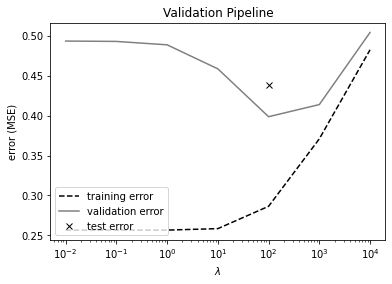

In [169]:
plt.xticks([])
plt.xlabel(r"$\lambda$")
plt.ylabel(r"error (MSE)")
plt.title(r"Validation Pipeline")
plt.xscale('log')
plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
plt.legend(loc='lower left')
plt.show()

# Precision, recall, and ROC curves

Same data as pipeline above, slightly bigger dataset

In [171]:
data = list(parseData(os.path.join(dataDir, "beer_50000.json")))[:10000]

Simple bag-of-words model (as in pipeline above, and in Chapter 8)

In [172]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

In [173]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [174]:
words = [x[1] for x in counts[:1000]]

In [175]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [176]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    ws = r.split()
    for w in ws:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Predict whether the ABV is above 6.7 (roughly, above average) from the review text

In [177]:
random.shuffle(data)

In [179]:
X = np.array([feature(d) for d in data])
y = np.array([d['beer/ABV'] > 6.7 for d in data])

Train on first 9000 reviews, test on last 1000

In [180]:
mod = sklearn.linear_model.LogisticRegression(max_iter=5000)
mod.fit(X[:9000],y[:9000])
predictions = mod.predict(X[9000:]) # Binary vector of predictions
correct = predictions == y[9000:]

Accuracy

In [181]:
sum(correct) / len(correct)

0.832

To compute precision and recall, we want the output probabilities (or scores) rather than the predicted labels

In [182]:
probs = mod.predict_proba(X[9000:]) # could also use mod.decision_function

Build a simple data structure that contains the score, the predicted label, and the actual label (on the test set)

In [183]:
probY = list(zip([p[1] for p in probs], [p[1] > 0.5 for p in probs], y[9000:]))

For example...

In [184]:
probY[:10]

[(0.9999998761452333, True, True),
 (0.01271711705895888, False, False),
 (0.9970690065462591, True, True),
 (0.00011257853310800643, False, False),
 (0.9506186857378048, True, True),
 (0.8510723302889783, True, False),
 (0.950775743505032, True, True),
 (0.001978896416399024, False, True),
 (0.9035540177310503, True, True),
 (0.08480323824175587, False, True)]

Sort this so that the most confident predictions come first

In [185]:
probY.sort(reverse=True)

For example...

In [186]:
probY[:10]

[(1.0, True, True),
 (0.9999999999999885, True, True),
 (0.9999999999999718, True, True),
 (0.9999999999999378, True, True),
 (0.9999999999998981, True, True),
 (0.9999999999980154, True, True),
 (0.999999999996765, True, True),
 (0.9999999999825313, True, True),
 (0.99999999978782, True, True),
 (0.9999999997676736, True, True)]

### Receiver operator characteristic (ROC) curve

In [187]:
xROC = []
yROC = []

for thresh in np.arange(0,1.01,0.01):
    preds = [x[0] > thresh for x in probY]
    labs = [x[2] for x in probY]
    if len(labs) == 0:
        continue
    
    TP = sum([(a and b) for (a,b) in zip(preds,labs)])
    FP = sum([(a and not b) for (a,b) in zip(preds,labs)])
    TN = sum([(not a and not b) for (a,b) in zip(preds,labs)])
    FN = sum([(not a and b) for (a,b) in zip(preds,labs)])
       
    TPR = TP / (TP + FN) # True positive rate
    FPR = FP / (TN + FP) # False positive rate
    xROC.append(FPR)
    yROC.append(TPR)

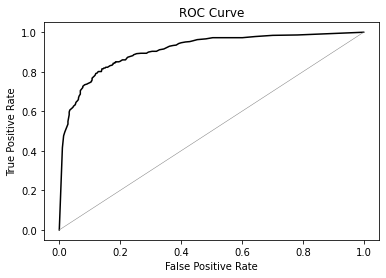

In [188]:
plt.plot(xROC,yROC,color='k')
plt.plot([0,1],[0,1], lw=0.5, color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### Precision recall curve

In [189]:
xPR = []
yPR = []

for i in range(1,len(probY)+1):
    preds = [x[1] for x in probY[:i]]
    labs = [x[2] for x in probY[:i]]
    prec = sum(labs) / len(labs)
    rec = sum(labs) / sum(y[9000:])
    xPR.append(rec)
    yPR.append(prec)

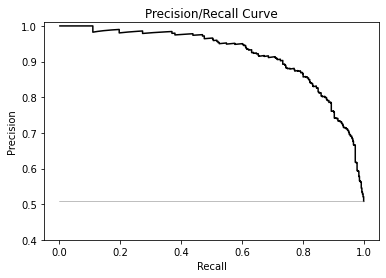

In [190]:
plt.plot(xPR,yPR,color='k')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.4,1.01)
plt.plot([0,1],[sum(y[9000:]) / 1000, sum(y[9000:]) / 1000], lw=0.5, color = 'grey')
plt.title("Precision/Recall Curve")
plt.show()

# Exercises

### 3.1

In [191]:
path = os.path.join(dataDir, "beer_50000.json")
f = open(path)
data = []
for l in f:
    data.append(eval(l))
f.close()

Count occurrences of each style

In [192]:
categoryCounts = defaultdict(int)
for d in data:
    categoryCounts[d['beer/style']] += 1

categories = [c for c in categoryCounts if categoryCounts[c] > 1000]

catID = dict(zip(list(categories),range(len(categories))))

Build one-hot encoding using common styles

In [193]:
def feat(d):
    feat = [0] * len(catID)
    if d['beer/style'] in catID:
        feat[catID[d['beer/style']]] = 1
    return feat + [1]

In [194]:
X = [feat(d) for d in data]
y = [d['beer/ABV'] > 5 for d in data]

In [195]:
mod = sklearn.linear_model.LogisticRegression()
mod.fit(X,y)

LogisticRegression()

Compute and report metrics

In [199]:
def metrics(y, ypred):
    TP = sum([(a and b) for (a,b) in zip(y, ypred)])
    TN = sum([(not a and not b) for (a,b) in zip(y, ypred)])
    FP = sum([(not a and b) for (a,b) in zip(y, ypred)])
    FN = sum([(a and not b) for (a,b) in zip(y, ypred)])

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)

    BER = 1 - 0.5*(TPR + TNR)
    
    print(f"TPR = {TPR}")
    print(f"TNR = {TNR}")
    print(f"BER = {BER}")

In [200]:
ypred = mod.predict(X)
metrics(y, ypred)

TPR = 0.9943454210202828
TNR = 0.27828418230563
BER = 0.3636851983370436


### 3.2

Balance the classifier using the 'balanced' option

In [201]:
mod = sklearn.linear_model.LogisticRegression(class_weight='balanced')
mod.fit(X,y)

LogisticRegression(class_weight='balanced')

In [202]:
ypred = mod.predict(X)
metrics(y, ypred)

TPR = 0.6779348494161033
TNR = 0.9751206434316354
BER = 0.1734722535761306


### 3.3

Precision/recall curves

In [203]:
probs = mod.predict_proba(X)

In [204]:
probY = list(zip([p[1] for p in probs], [p[1] > 0.5 for p in probs], y))

In [205]:
probY.sort(reverse=True) # Sort data by confidence

In [206]:
xPR = []
yPR = []

for i in range(1,len(probY)+1,100):
    preds = [x[1] for x in probY[:i]]
    labs = [x[2] for x in probY[:i]]
    prec = sum(labs) / len(labs)
    rec = sum(labs) / sum(y)
    xPR.append(rec)
    yPR.append(prec)

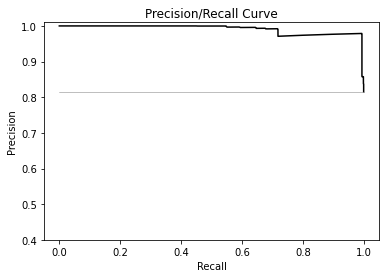

In [207]:
plt.plot(xPR,yPR,color='k')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.4,1.01)
plt.plot([0,1],[sum(y) / len(y), sum(y) / len(y)], lw=0.5, color = 'grey')
plt.title("Precision/Recall Curve")
plt.show()

### 3.4

Model pipeline

In [208]:
dataTrain = data[:25000]
dataValid = data[25000:37500]
dataTest = data[37500:]

In [209]:
def pipeline(reg):
    mod = linear_model.LogisticRegression(C=reg, class_weight='balanced')
    
    X = [feat(d) for d in dataTrain]
    y = [d['beer/ABV'] > 5 for d in dataTrain]

    Xvalid = [feat(d) for d in dataValid]
    yvalid = [d['beer/ABV'] > 5 for d in dataValid]
    Xtest = [feat(d) for d in dataTest]
    ytest = [d['beer/ABV'] > 5 for d in dataTest]
    
    mod.fit(X,y)
    ypredValid = mod.predict(Xvalid)
    ypredTest = mod.predict(Xtest)
    
    # validation
    
    TP = sum([(a and b) for (a,b) in zip(yvalid, ypredValid)])
    TN = sum([(not a and not b) for (a,b) in zip(yvalid, ypredValid)])
    FP = sum([(not a and b) for (a,b) in zip(yvalid, ypredValid)])
    FN = sum([(a and not b) for (a,b) in zip(yvalid, ypredValid)])
    
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    
    BER = 1 - 0.5*(TPR + TNR)
    
    print("C = " + str(reg) + "; validation BER = " + str(BER))
    
    # test

    TP = sum([(a and b) for (a,b) in zip(ytest, ypredTest)])
    TN = sum([(not a and not b) for (a,b) in zip(ytest, ypredTest)])
    FP = sum([(not a and b) for (a,b) in zip(ytest, ypredTest)])
    FN = sum([(a and not b) for (a,b) in zip(ytest, ypredTest)])
    
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    
    BER = 1 - 0.5*(TPR + TNR)
    
    print("C = " + str(reg) + "; test BER = " + str(BER))

    return mod

In [210]:
for c in [0.000001, 0.00001, 0.0001, 0.001]:
    pipeline(c)

C = 1e-06; validation BER = 0.16646546520651895
C = 1e-06; test BER = 0.2640150292967679
C = 1e-05; validation BER = 0.28744502888678103
C = 1e-05; test BER = 0.39631747406856366
C = 0.0001; validation BER = 0.28744502888678103
C = 0.0001; test BER = 0.39631747406856366
C = 0.001; validation BER = 0.28744502888678103
C = 0.001; test BER = 0.39631747406856366


### 3.5

Fit the classification problem using a regular linear regressor

In [211]:
y_reg = [2.0*a - 1 for a in y] # Map data to {-1.0,1.0}

In [212]:
y_reg[:10]

[-1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

In [213]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y_reg)

LinearRegression(fit_intercept=False)

In [214]:
yreg_pred = model.predict(X)
yreg_pred = [a > 0 for a in yreg_pred] # Map the outputs back to binary predictions

In [215]:
metrics(y, yreg_pred)

TPR = 0.9943454210202828
TNR = 0.27828418230563
BER = 0.3636851983370436
